## Données

Informations sur cet ensemble de données : https://fred.stlouisfed.org/series/IPN31152N


Unités :  Indice 2012=100, pas d'ajustement de saisonnalité

Fréquence :  Mensuelle

L'indice de production industrielle (IP) mesure la production réelle de tous les établissements concernés situés aux États-Unis, quel que soit leur propriétaire, mais pas ceux situés sur le territoire américain.

SCIAN = 31152

Code source : IP.N31152.N

Citation suggérée :
Conseil des gouverneurs de la Réserve fédérale (États-Unis), Production industrielle : Biens non durables : Glaces et desserts glacés [IPN31152N], extrait de FRED, Federal Reserve Bank of St. Louis ; https://fred.stlouisfed.org/series/IPN31152N, 16 novembre 2019.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

(622, 1)
            Production Industrielle
DATE                               
1972-01-01                  60.1529
1972-02-01                  67.2738
1972-03-01                  74.4713
1972-04-01                  78.3607
1972-05-01                  85.0335


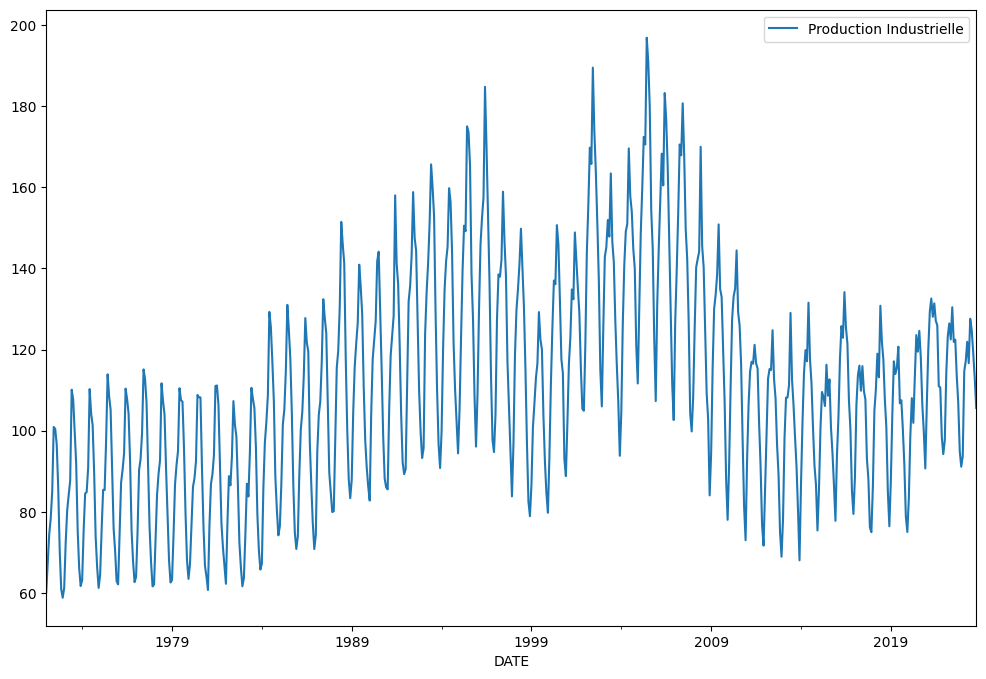

In [113]:
df = pd.read_csv('IPN31152N.csv', parse_dates=True, index_col='DATE')
df.columns = ['Production Industrielle']
print(df.shape)
print(df.head())
df.plot(figsize=(12,8));

In [114]:
test_size = 24
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [115]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [116]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 18 # longueur de la séquence
batch_size = 1 # nombre d'échantillons par lot
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [118]:
def create_model(length, n_features):
    model = Sequential()
    model.add(LSTM(200, activation="relu", input_shape=(length, n_features), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse' , metrics=['mae'])
    model.summary()
    return model

n_features = 1
model = create_model(length, n_features)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 18, 200)           161600    
                                                                 
 dropout_22 (Dropout)        (None, 18, 200)           0         


                                                                 
 lstm_57 (LSTM)              (None, 100)               120400    
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                                 
Total params: 282101 (1.08 MB)
Trainable params: 282101 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop])
epochs_processed = len(model.history.epoch)
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

Epoch 1/50
580/580 [==============================] - 7s 9ms/step - loss: 0.0312 - mae: 0.1446 - val_loss: 0.0103 - val_mae: 0.0880
Epoch 2/50
580/580 [==============================] - 5s 9ms/step - loss: 0.0242 - mae: 0.1292 - val_loss: 0.0036 - val_mae: 0.0542
Epoch 3/50
580/580 [==============================] - 5s 9ms/step - loss: 0.0119 - mae: 0.0879 - val_loss: 0.0024 - val_mae: 0.0469
Epoch 4/50
580/580 [==============================] - 5s 9ms/step - loss: 0.0088 - mae: 0.0755 - val_loss: 0.0037 - val_mae: 0.0472
Epoch 5/50
580/580 [==============================] - 5s 9ms/step - loss: 0.0071 - mae: 0.0672 - val_loss: 0.0024 - val_mae: 0.0335
Epoch 6/50
580/580 [==============================] - 5s 9ms/step - loss: 0.0067 - mae: 0.0641 - val_loss: 0.0046 - val_mae: 0.0654


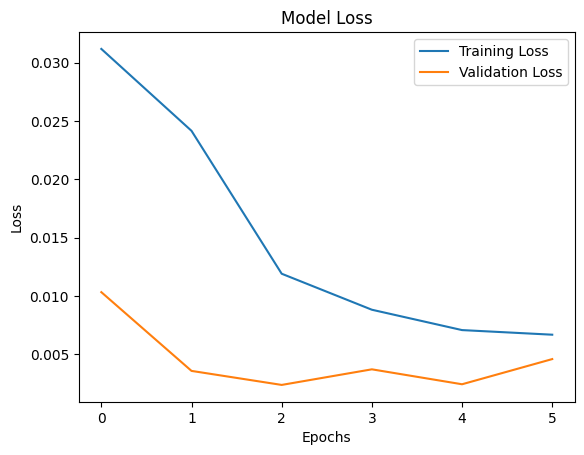

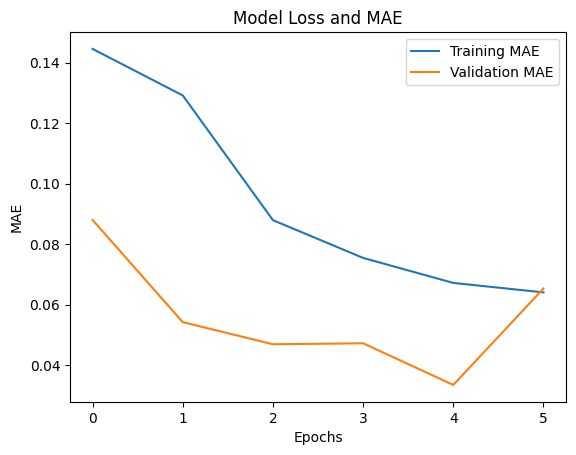

In [120]:
epochs = range(len(loss))

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, model.history.history['mae'], label='Training MAE')
plt.plot(epochs, model.history.history['val_mae'], label='Validation MAE')
plt.title('Model Loss and MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()



1/1 [==============================] - 0s 27ms/step


C:\Users\hajdaini\AppData\Local\Temp\ipykernel_3016\3963278392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


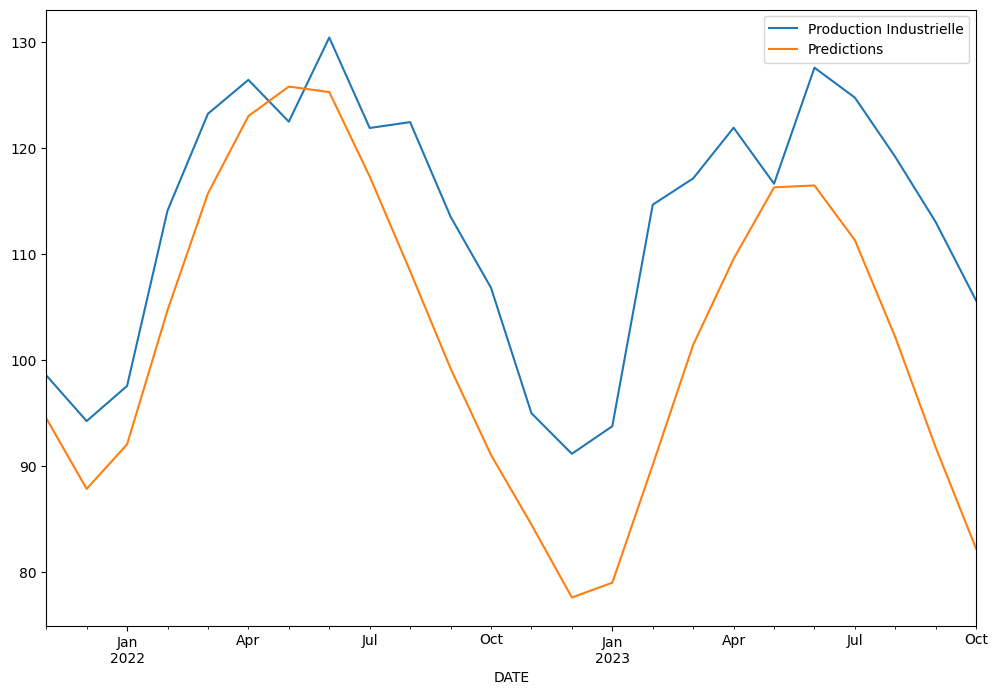

In [121]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,8));

In [122]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [123]:
n_features = 1
model = create_model(length, n_features)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 18, 200)           161600    
                                                                 
 dropout_23 (Dropout)        (None, 18, 200)           0         
                                                                 
 lstm_59 (LSTM)              (None, 100)               120400    
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 282101 (1.08 MB)
Trainable params: 282101 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
model.fit(generator, epochs=epochs_processed)

Epoch 1/6
604/604 [==============================] - 7s 9ms/step - loss: 0.0322 - mae: 0.1456
Epoch 2/6
604/604 [==============================] - 5s 8ms/step - loss: 0.0242 - mae: 0.1252
Epoch 3/6
604/604 [==============================] - 5s 8ms/step - loss: 0.0108 - mae: 0.0813
Epoch 4/6
604/604 [==============================] - 5s 9ms/step - loss: 0.0091 - mae: 0.0727
Epoch 5/6
604/604 [==============================] - 5s 9ms/step - loss: 0.0074 - mae: 0.0681
Epoch 6/6
604/604 [==============================] - 5s 9ms/step - loss: 0.0063 - mae: 0.0617


In [125]:
forecast = []
periods = 12 # nombre de mois à prédire
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 22ms/step


In [126]:
last_index = df.index[-1]
start = last_index + pd.DateOffset(months=1)
print(df.tail())
forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start=start,periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])
forecast_df

            Production Industrielle
DATE                               
2023-06-01                 127.5746
2023-07-01                 124.7469
2023-08-01                 119.1456
2023-09-01                 112.9904
2023-10-01                 105.5802


,Forecast
2023-11-01,92.656730
2023-12-01,92.607255
2024-01-01,97.562663
2024-02-01,109.173363
2024-03-01,116.150928
2024-04-01,122.612461
2024-05-01,127.565221
2024-06-01,128.473213
2024-07-01,122.269849
2024-08-01,114.903318


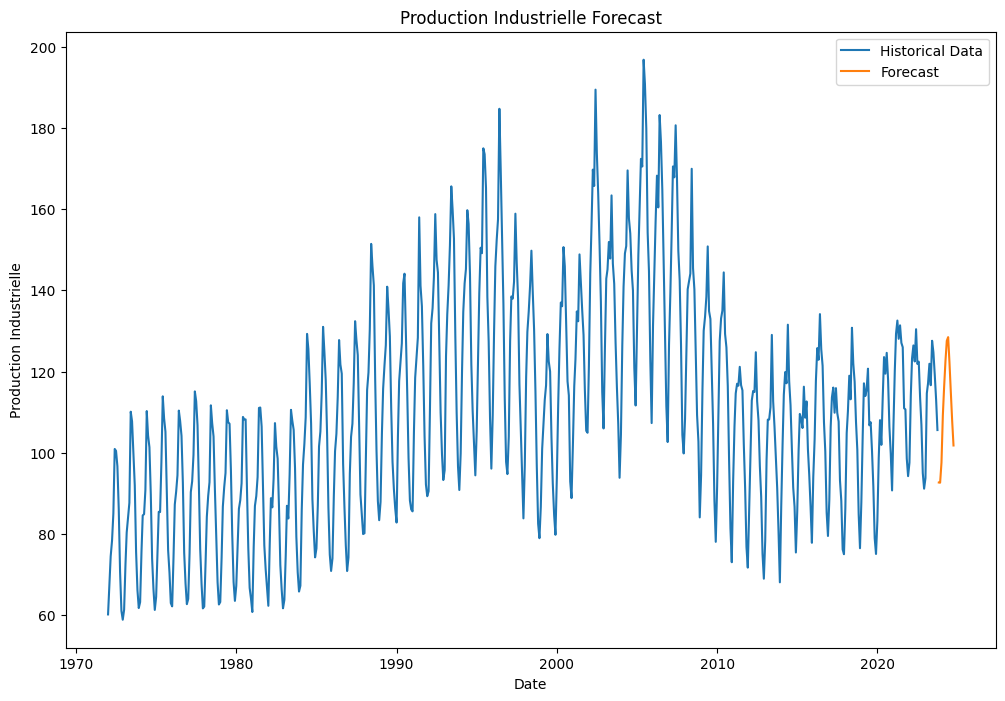

(610.0, 657.0)

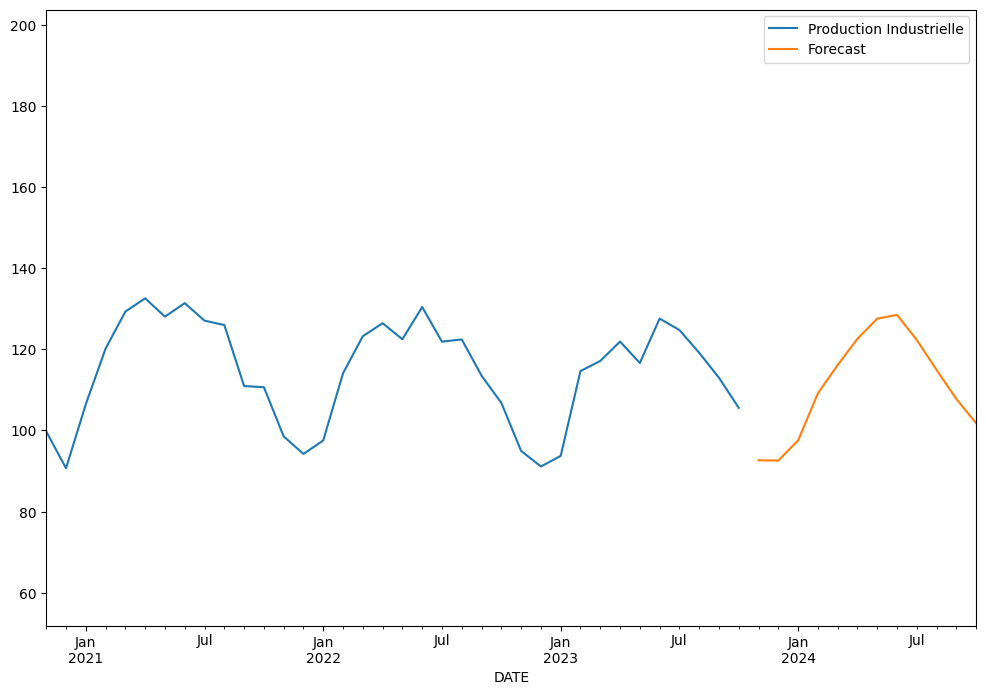

In [127]:
combined_data = pd.concat([df, forecast_df])

# Plot the combined data
plt.figure(figsize=(12, 8))
plt.plot(combined_data.index, combined_data['Production Industrielle'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
plt.title('Production Industrielle Forecast')
plt.xlabel('Date')
plt.ylabel('Production Industrielle')
plt.legend()
plt.show()

ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.xlim(df.tail(36).index[0], forecast_df.index[-1])

